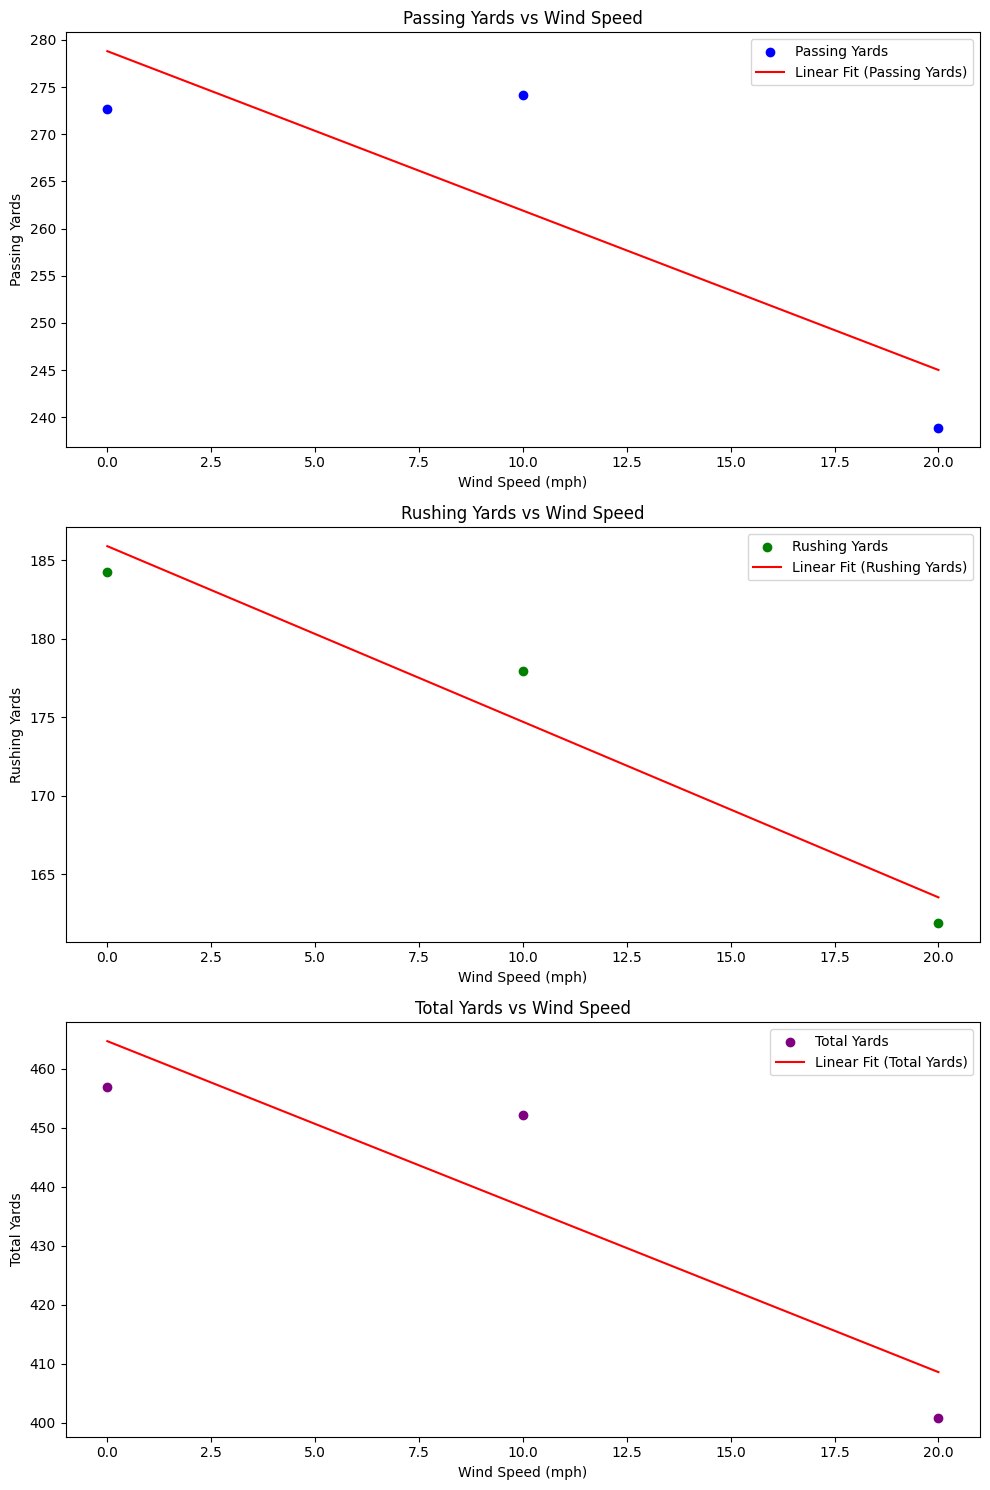

R-squared for Passing Yards: 0.716373671576893
R-squared for Rushing Yards: 0.9403685527897574
R-squared for Total Yards: 0.8133967959492339


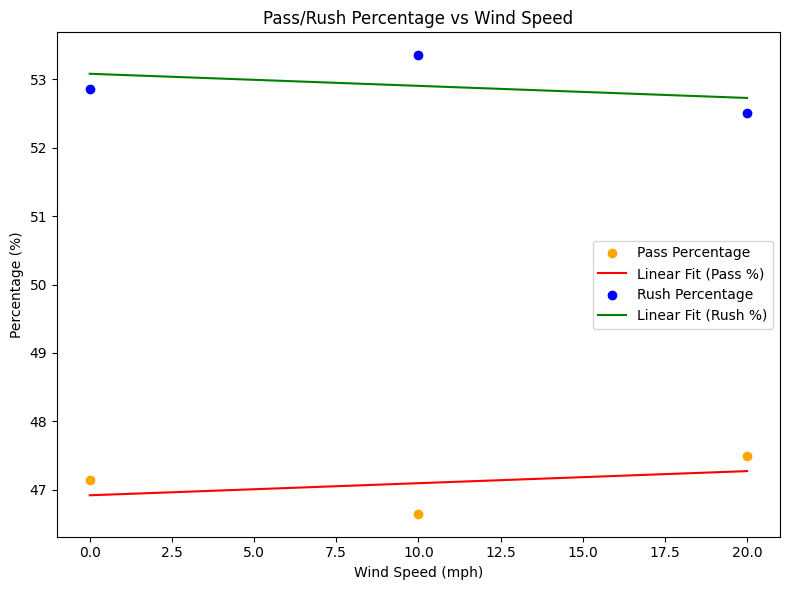

R-squared for Pass Percentage: 0.1723625020128381
R-squared for Rush Percentage: 0.17236250201283332


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import psycopg2



import warnings
warnings.filterwarnings("ignore")

# Connect to my database
conn = psycopg2.connect(
    host="",
    port="",
    database="",
    user="",
    password=""
)

# Query for UCLA
ucla_query = """
SELECT date, raw_location, opponent, 
       passing_cmp, passing_att, completion_pct, passing_yds, passing_td, rushing_att, rushing_yds, 
       rushing_avg, rushing_td, total_plays, total_yards, avg_yds, pass_first_downs, rush_first_downs,
       first_down_pens, total_first_downs, total_penalties, total_penalties_yds, total_fum, total_int, 
       total_to, windspeed_mph
FROM UCLA_Offensive_Stats;
"""
ucla_kicking = pd.read_sql(ucla_query, conn)

# Query for USC
usc_query = """
SELECT date, raw_location, opponent, 
       passing_cmp, passing_att, completion_pct, passing_yds, passing_td, rushing_att, rushing_yds, 
       rushing_avg, rushing_td, total_plays, total_yards, avg_yds, pass_first_downs, rush_first_downs,
       first_down_pens, total_first_downs, total_penalties, total_penalties_yds, total_fum, total_int, 
       total_to, windspeed_mph
FROM USC_Offensive_Stats;
"""
usc_kicking = pd.read_sql(usc_query, conn)

# Query for Washington
washington_query = """
SELECT date, raw_location, opponent, 
       passing_cmp, passing_att, completion_pct, passing_yds, passing_td, rushing_att, rushing_yds, 
       rushing_avg, rushing_td, total_plays, total_yards, avg_yds, pass_first_downs, rush_first_downs,
       first_down_pens, total_first_downs, total_penalties, total_penalties_yds, total_fum, total_int, 
       total_to, windspeed_mph
FROM Washington_Offensive_Stats;
"""
uw_kicking = pd.read_sql(washington_query, conn)

# Query for Oregon
oregon_query = """
SELECT date, raw_location, opponent, 
       passing_cmp, passing_att, completion_pct, passing_yds, passing_td, rushing_att, rushing_yds, 
       rushing_avg, rushing_td, total_plays, total_yards, avg_yds, pass_first_downs, rush_first_downs,
       first_down_pens, total_first_downs, total_penalties, total_penalties_yds, total_fum, total_int, 
       total_to, windspeed_mph
FROM Oregon_Offensive_Stats;
"""
oregon_kicking = pd.read_sql(oregon_query, conn)

# Combine all 4 teams' data into one df
combined_data = pd.concat([ucla_kicking, usc_kicking, uw_kicking, oregon_kicking], ignore_index=True)

# wind speed bins (in mph)
wind_speed_bins = [0, 10, 20, float('inf')]
wind_speed_labels = ['0-10 mph', '10-20 mph', '20+ mph']

# new column for wind speed ranges
combined_data['Wind_Speed_Range'] = pd.cut(combined_data['windspeed_mph'], bins=wind_speed_bins, labels=wind_speed_labels, right=False)


wind_grouped = combined_data.groupby('Wind_Speed_Range').agg({
    'passing_yds': 'mean',
    'rushing_yds': 'mean',
    'total_yards': 'mean',
    'passing_att': 'sum',
    'rushing_att': 'sum'
}).reset_index()

# run-pass percentage
wind_grouped['pass_percentage'] = (wind_grouped['passing_att'] / (wind_grouped['passing_att'] + wind_grouped['rushing_att'])) * 100
wind_grouped['rush_percentage'] = (wind_grouped['rushing_att'] / (wind_grouped['passing_att'] + wind_grouped['rushing_att'])) * 100

# Perform linear regression for passing yards, rushing yards, and total yards vs wind speed
X = np.array([0, 10, 20]).reshape(-1, 1)  # Wind speed bin midpoints
y_passing_yds = wind_grouped['passing_yds'].values
y_rushing_yds = wind_grouped['rushing_yds'].values
y_total_yards = wind_grouped['total_yards'].values

# Fit models
model_passing = LinearRegression().fit(X, y_passing_yds)
model_rushing = LinearRegression().fit(X, y_rushing_yds)
model_total = LinearRegression().fit(X, y_total_yards)

# Predictions
y_pred_passing = model_passing.predict(X)
y_pred_rushing = model_rushing.predict(X)
y_pred_total = model_total.predict(X)

# Scatter plot with linear regression line
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Passing yards vs wind speed
axs[0].scatter(X, y_passing_yds, color='blue', label='Passing Yards')
axs[0].plot(X, y_pred_passing, color='red', label='Linear Fit (Passing Yards)')
axs[0].set_title('Passing Yards vs Wind Speed')
axs[0].set_xlabel('Wind Speed (mph)')
axs[0].set_ylabel('Passing Yards')
axs[0].legend()

# Rushing yards vs wind speed
axs[1].scatter(X, y_rushing_yds, color='green', label='Rushing Yards')
axs[1].plot(X, y_pred_rushing, color='red', label='Linear Fit (Rushing Yards)')
axs[1].set_title('Rushing Yards vs Wind Speed')
axs[1].set_xlabel('Wind Speed (mph)')
axs[1].set_ylabel('Rushing Yards')
axs[1].legend()

# Total yards vs wind speed
axs[2].scatter(X, y_total_yards, color='purple', label='Total Yards')
axs[2].plot(X, y_pred_total, color='red', label='Linear Fit (Total Yards)')
axs[2].set_title('Total Yards vs Wind Speed')
axs[2].set_xlabel('Wind Speed (mph)')
axs[2].set_ylabel('Total Yards')
axs[2].legend()

plt.tight_layout()
plt.show()

# R-squared
print(f"R-squared for Passing Yards: {r2_score(y_passing_yds, y_pred_passing)}")
print(f"R-squared for Rushing Yards: {r2_score(y_rushing_yds, y_pred_rushing)}")
print(f"R-squared for Total Yards: {r2_score(y_total_yards, y_pred_total)}")

# Additional linear regression for pass/rush percentage vs wind speed
y_pass_percentage = wind_grouped['pass_percentage'].values
y_rush_percentage = wind_grouped['rush_percentage'].values

# Fit linear regression models for pass and rush percentages
model_pass_percentage = LinearRegression().fit(X, y_pass_percentage)
model_rush_percentage = LinearRegression().fit(X, y_rush_percentage)

# Predictions for pass and rush percentages
y_pred_pass_percentage = model_pass_percentage.predict(X)
y_pred_rush_percentage = model_rush_percentage.predict(X)

# Plot run-pass percentage vs wind speed
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X, y_pass_percentage, color='orange', label='Pass Percentage')
ax.plot(X, y_pred_pass_percentage, color='red', label='Linear Fit (Pass %)')
ax.scatter(X, y_rush_percentage, color='blue', label='Rush Percentage')
ax.plot(X, y_pred_rush_percentage, color='green', label='Linear Fit (Rush %)')

ax.set_title('Pass/Rush Percentage vs Wind Speed')
ax.set_xlabel('Wind Speed (mph)')
ax.set_ylabel('Percentage (%)')
ax.legend()

plt.tight_layout()
plt.show()

# Print R-squared
print(f"R-squared for Pass Percentage: {r2_score(y_pass_percentage, y_pred_pass_percentage)}")
print(f"R-squared for Rush Percentage: {r2_score(y_rush_percentage, y_pred_rush_percentage)}")


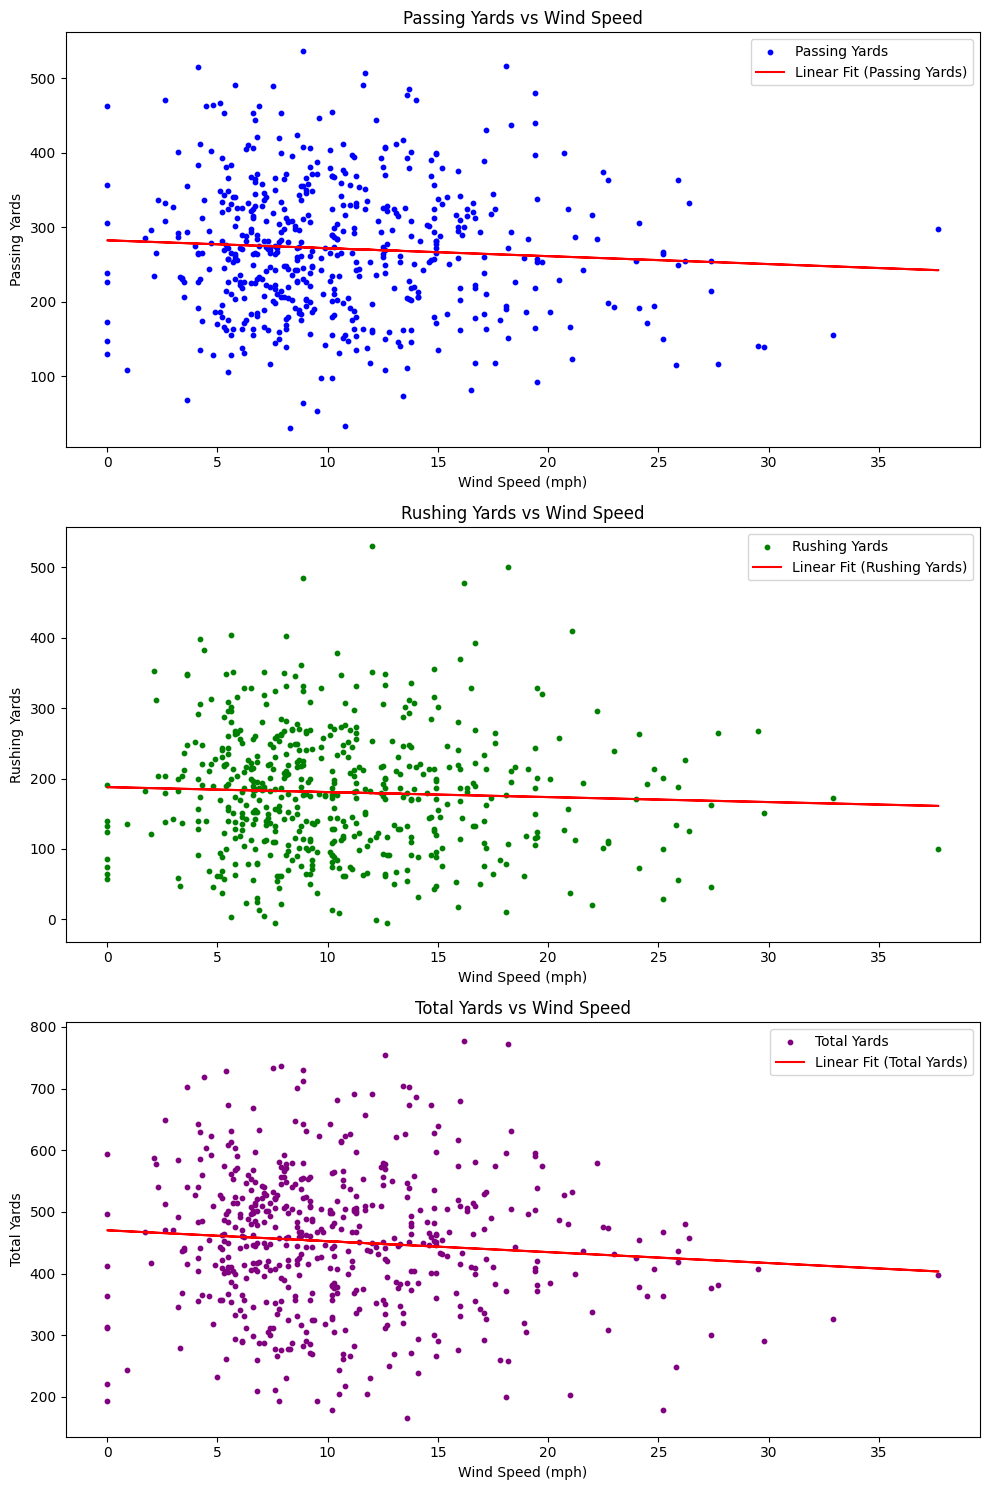

R-squared for Passing Yards: 0.004343866319744594
R-squared for Rushing Yards: 0.002000566540079407
R-squared for Total Yards: 0.0074820017651237025


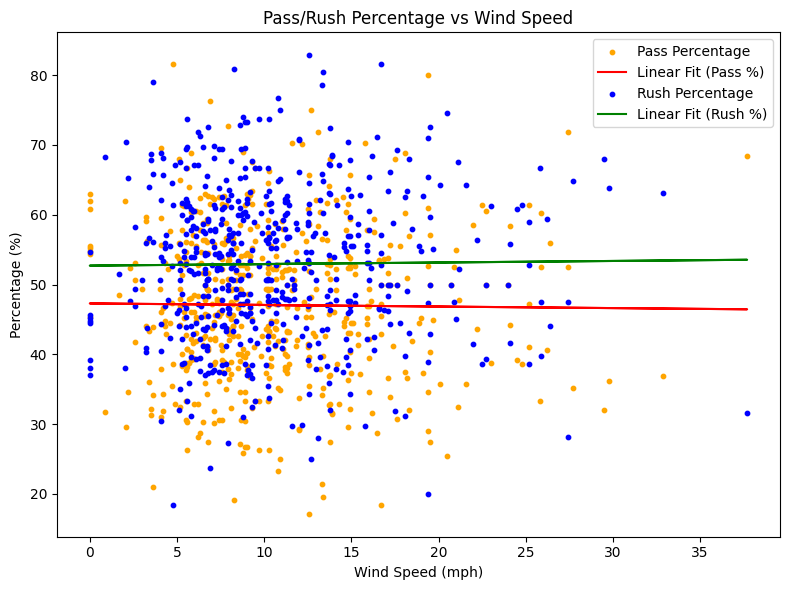

R-squared for Pass Percentage: 0.00013244026858860725
R-squared for Rush Percentage: 0.00013244026858849622


In [2]:

combined_data = pd.concat([ucla_kicking, usc_kicking, uw_kicking, oregon_kicking], ignore_index=True)

# Remove rows with missing windspeed values
combined_data = combined_data.dropna(subset=['windspeed_mph', 'passing_yds', 'rushing_yds', 'total_yards'])

# Prepare the data for linear regression
X = combined_data['windspeed_mph'].values.reshape(-1, 1)  # Wind speed (independent variable)
y_passing = combined_data['passing_yds'].values  # Passing yards (dependent variable)
y_rushing = combined_data['rushing_yds'].values  # Rushing yards (dependent variable)
y_total = combined_data['total_yards'].values    # Total yards (dependent variable)

# Fit linear regression models
model_passing = LinearRegression().fit(X, y_passing)
model_rushing = LinearRegression().fit(X, y_rushing)
model_total = LinearRegression().fit(X, y_total)

# Predict values using the models
y_pred_passing = model_passing.predict(X)
y_pred_rushing = model_rushing.predict(X)
y_pred_total = model_total.predict(X)

# Scatter plot with linear regression line for passing, rushing, and total yards
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Passing Yards vs Wind Speed
axs[0].scatter(combined_data['windspeed_mph'], combined_data['passing_yds'], color='blue', s=10, label='Passing Yards')
axs[0].plot(combined_data['windspeed_mph'], y_pred_passing, color='red', label='Linear Fit (Passing Yards)')
axs[0].set_title('Passing Yards vs Wind Speed')
axs[0].set_xlabel('Wind Speed (mph)')
axs[0].set_ylabel('Passing Yards')
axs[0].legend()

# Rushing Yards vs Wind Speed
axs[1].scatter(combined_data['windspeed_mph'], combined_data['rushing_yds'], color='green', s=10, label='Rushing Yards')
axs[1].plot(combined_data['windspeed_mph'], y_pred_rushing, color='red', label='Linear Fit (Rushing Yards)')
axs[1].set_title('Rushing Yards vs Wind Speed')
axs[1].set_xlabel('Wind Speed (mph)')
axs[1].set_ylabel('Rushing Yards')
axs[1].legend()

# Total Yards vs Wind Speed
axs[2].scatter(combined_data['windspeed_mph'], combined_data['total_yards'], color='purple', s=10, label='Total Yards')
axs[2].plot(combined_data['windspeed_mph'], y_pred_total, color='red', label='Linear Fit (Total Yards)')
axs[2].set_title('Total Yards vs Wind Speed')
axs[2].set_xlabel('Wind Speed (mph)')
axs[2].set_ylabel('Total Yards')
axs[2].legend()

plt.tight_layout()
plt.show()

# R-squared
print(f"R-squared for Passing Yards: {r2_score(y_passing, y_pred_passing)}")
print(f"R-squared for Rushing Yards: {r2_score(y_rushing, y_pred_rushing)}")
print(f"R-squared for Total Yards: {r2_score(y_total, y_pred_total)}")

combined_data['pass_percentage'] = (combined_data['passing_att'] / (combined_data['passing_att'] + combined_data['rushing_att'])) * 100
combined_data['rush_percentage'] = (combined_data['rushing_att'] / (combined_data['passing_att'] + combined_data['rushing_att'])) * 100


y_pass_percentage = combined_data['pass_percentage'].values
y_rush_percentage = combined_data['rush_percentage'].values

# Fit models
model_pass_percentage = LinearRegression().fit(X, y_pass_percentage)
model_rush_percentage = LinearRegression().fit(X, y_rush_percentage)

# Predictions for pass and rush percentages
y_pred_pass_percentage = model_pass_percentage.predict(X)
y_pred_rush_percentage = model_rush_percentage.predict(X)

# Plot run-pass percentage vs wind speed
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(combined_data['windspeed_mph'], combined_data['pass_percentage'], color='orange', s=10, label='Pass Percentage')
ax.plot(combined_data['windspeed_mph'], y_pred_pass_percentage, color='red', label='Linear Fit (Pass %)')
ax.scatter(combined_data['windspeed_mph'], combined_data['rush_percentage'], color='blue', s=10, label='Rush Percentage')
ax.plot(combined_data['windspeed_mph'], y_pred_rush_percentage, color='green', label='Linear Fit (Rush %)')

ax.set_title('Pass/Rush Percentage vs Wind Speed')
ax.set_xlabel('Wind Speed (mph)')
ax.set_ylabel('Percentage (%)')
ax.legend()

plt.tight_layout()
plt.show()

# Print R-squared values for pass and rush percentages
print(f"R-squared for Pass Percentage: {r2_score(y_pass_percentage, y_pred_pass_percentage)}")
print(f"R-squared for Rush Percentage: {r2_score(y_rush_percentage, y_pred_rush_percentage)}")
